## Image Classification of Australian Animals

William Li z5257749



In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import load_img, img_to_array

In [26]:
tf.keras.utils.set_random_seed(126)

### Load data and process into numpy array

In [27]:
labels = []
data_resized = []
data_padded = []

folder_list = os.listdir("Data")
for folder_name in folder_list:
    folder_path = os.path.join("Data", folder_name)
    
    # There are some system files that are not directories
    if not os.path.isdir(folder_path):
        continue
        
    file_list = os.listdir(folder_path)
    for file_name in file_list:
        if file_name.endswith('.jpeg'):
            file_path = os.path.join(folder_path, file_name)
            img = load_img(file_path)
            img_array = img_to_array(img)
            img_array /= 255
            
            img_resized = tf.image.resize(img_array, (128, 128))
            data_resized.append(img_resized)
            
            img_padded = tf.image.resize_with_pad(img_array, 128, 128)
            data_padded.append(img_padded)
            
            labels.append(folder_name)
            
data_resized = np.array(data_resized)
data_padded = np.array(data_padded)
labels = np.array(labels)

train_test_split used 3 times to segment data into 4 sets. Their purpose and number of examples per class are:
- Training (96)
- Validation for early-stopping (32)
- Validation for hyperparameter tuning (32) and
- Test (40)

Validation set for early-stopping explicitly defined here rather than using validation_split in model.train as stratify is only available here.

In [29]:
X_train_val_resized, X_test_resized, X_train_val_padded, X_test_padded, y_train_val, y_test =\
train_test_split(data_resized, data_padded, labels, test_size=0.2,
                 shuffle=True, random_state=126, stratify=labels)

X_train_resized, X_val_resized, X_train_padded, X_val_padded, y_train, y_val=\
train_test_split(X_train_val_resized, X_train_val_padded, y_train_val, test_size=0.2,
                 shuffle=True, random_state=126, stratify=y_train_val)

X_train_resized, X_es_resized, X_train_padded, X_es_padded, y_train, y_es=\
train_test_split(X_train_resized, X_train_padded, y_train, test_size=0.25,
                 shuffle=True, random_state=126, stratify=y_train)

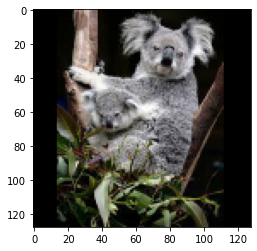